# Create monthly CESM atmospheric deposition files

NCAR CESM output:
Community Earth System Model (Community Atmosphere Model - CAM https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2013MS000279) output: https://www.earthsystemgrid.org/; CESM1 CAM5 BGC Large Ensemble Atmosphere Post Processed Data, Monthly Averages.

Specific run output: https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.html

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import matplotlib
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
print('Run id: ucar.cgd.ccsm4.CESM_CAM5_BGC_LE')

Run id: ucar.cgd.ccsm4.CESM_CAM5_BGC_LE


In [3]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
tmask = np.array(tmask[0,:,:,:])

mesh  = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
mlons = np.array(mesh.variables['nav_lon'])
mlats = np.array(mesh.variables['nav_lat'])
mlons = np.array(mlons)
mlats = np.array(mlats)

cond = (tmask > 0.1) 
Z_masked = np.ma.masked_where(cond, tmask) 

In [4]:
def interp_np(nav_lon, nav_lat, var_in, lon_ANHA12, lat_ANHA12):
    ''' Interpolate some field to ANHA12 grid.
        The function is based on the bilinear interpolation in scipy, griddata 
        =======================================================================
            nav_lon, nav_lat        : input field lon/lat
            lon_ANHA12, lat_ANHA12  : ANHA12 defined lons/lats
            var_in                  : 2-D model variable
    '''
    from scipy.interpolate import griddata
    LatLonPair = (nav_lon.flatten(), nav_lat.flatten())
    a = nav_lon.flatten()
    b = nav_lat.flatten()
    c = var_in.flatten()
    print(a.shape, b.shape, c.shape, lon_ANHA12.shape, lat_ANHA12.shape)
    var_out = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='linear')
    # Take nearest neighbour interpolation to fill nans
    var_fill = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='nearest')
    
    var_out[np.isnan(var_out)] = var_fill[np.isnan(var_out)]
    return var_out

In [5]:
def save_file(filename, field1, field2, field3):
    ncd = nc.Dataset(filename, 'w', zlib=True)
#     nc_tools.init_dataset_attrs(
#         ncd,
#         title='dust input field',
#         notebook_name='',
#         nc_filepath='./monthly_CESM_forcing.nc',
#         comment='CESM ucar.cgd.ccsm4.CESM_CAM5_BGC_LE dust deposition field')

    ncd.createDimension('x',len(mesh.dimensions['x']))
    ncd.createDimension('y',len(mesh.dimensions['y']))
    ncd.createDimension('time_counter',None)
    
    # variables
    fine_dust             = ncd.createVariable('fdust', 'float64', ('y','x'))
    fine_dust.units       = 'g/m2/s'
    fine_dust.long_name   = 'Fine dust deposition flux'  
    fine_dust.coordinates = 'nav_lon nav_lat'
    fine_dust[:]          = field1
    
    coarse_dust             = ncd.createVariable('cdust', 'float64', ('y','x'))
    coarse_dust.units       = 'g/m2/s'
    coarse_dust.long_name   = 'Coarse dust deposition flux'  
    coarse_dust.coordinates = 'nav_lon nav_lat'
    coarse_dust[:]          = field2
    
    black_c             = ncd.createVariable('bc', 'float64', ('y','x'))
    black_c.units       = 'g/m2/s'
    black_c.long_name   = 'Black carbon deposition flux'  
    black_c.coordinates = 'nav_lon nav_lat'
    black_c[:]          = field3
    
    print('saved ', filename)

    ncd.close()
    return

For Mode MAM3 (https://www.geosci-model-dev.net/5/709/2012/):

- a1 --- Aitken mode --- 0.015-0.053 μm
- a2 --- Accumulation mode --- 0.058-0.27 μm
- a3 --- Coarse mode --- 0.80-3.65 μm

Indicate year for which to create files:

In [6]:
file_year = 2002

Load data:

In [7]:
folder = '/ocean/brogalla/GEOTRACES/data/NCAR/'
dst_a1DDF_f   = 'merged_dst_a1DDF.nc'
dst_a1SFWET_f = 'merged_dst_a1SFWET.nc'
dst_a3DDF_f   = 'merged_dst_a3DDF.nc'
dst_a3SFWET_f = 'merged_dst_a3SFWET.nc'
bc_a1DDF_f    = 'merged_bc_a1DDF.nc'
bc_a1SFWET_f  = 'merged_bc_a1SFWET.nc'

dst_a1D = nc.Dataset(folder+dst_a1DDF_f)
dst_a1S = nc.Dataset(folder+dst_a1SFWET_f)
dst_a3D = nc.Dataset(folder+dst_a3DDF_f)
dst_a3S = nc.Dataset(folder+dst_a3SFWET_f)
bc_a1D  = nc.Dataset(folder+bc_a1DDF_f)
bc_a1S  = nc.Dataset(folder+bc_a1SFWET_f)

In [8]:
dst_a1DDF   = dst_a1D.variables['dst_a1DDF']
dst_a1SFWET = dst_a1S.variables['dst_a1SFWET']
dst_a3DDF   = dst_a3D.variables['dst_a3DDF']
dst_a3SFWET = dst_a3S.variables['dst_a3SFWET']
BC_a1DDF    = bc_a1D.variables['bc_a1DDF']
BC_a1SFWET  = bc_a1S.variables['bc_a1SFWET']

In [9]:
dst_a1DDF

<class 'netCDF4._netCDF4.Variable'>
float32 dst_a1DDF(time, lat, lon)
    long_name: dst_a1 dry deposition flux at bottom (grav + turb)
    units: kg/m2/s
    cell_methods: time: mean
unlimited dimensions: time
current shape = (2772, 192, 288)
filling off

In [10]:
lon  = dst_a1D.variables['lon']
lat  = dst_a1D.variables['lat']
date = dst_a1D.variables['date']

In [11]:
lon = np.array(lon)
for i in range(0,len(lon)):
    if lon[i] >= 180:
        lon[i] = -360+lon[i]

In [12]:
# change lons and lats array dimensions: (192x288)
lons, lats = np.meshgrid(lon,lat)
lons=np.array(lons)
lats=np.array(lats)

identify array indices corresponding to start and end of file_year:

In [13]:
file_date_start = file_year*10000 + 101
file_date_end = file_year*10000 + 1201

In [14]:
start_index = []
end_index = []

for i in range(0,len(date)):
    if date[i] == file_date_start:
        start_index = i
    elif date[i] == file_date_end:
        end_index = i
        
print('start index: ', start_index)
print('end index: ', end_index)

start index:  1823
end index:  1834


In [15]:
print(date[start_index], date[end_index])

20020101 20021201


Sum wet and dry deposition fields & zero any negative deposition fluxes:

In [16]:
dst_a1DDF = np.array(dst_a1DDF)
dst_a1SFWET = np.array(dst_a1SFWET)
dst_a3DDF = np.array(dst_a3DDF)
dst_a3SFWET = np.array(dst_a3SFWET)
BC_a1DDF = np.array(BC_a1DDF)
BC_a1SFWET = np.array(BC_a1SFWET)

In [17]:
# zero negative deposition fluxes:
dst_a1DDF[dst_a1DDF < 0] = 0
dst_a1SFWET[dst_a1SFWET < 0] = 0
dst_a3DDF[dst_a3DDF < 0] = 0
dst_a3SFWET[dst_a3SFWET < 0] = 0
BC_a1DDF[BC_a1DDF < 0] = 0
BC_a1SFWET[BC_a1SFWET < 0] = 0

Convert kg/m2/s to g/m2/s

In [18]:
dst_a1 = np.add(dst_a1DDF[start_index:end_index+1,:,:]*10**3, dst_a1SFWET[start_index:end_index+1, :,:]*10**3)
dst_a3 = np.add(dst_a3DDF[start_index:end_index+1,:,:]*10**3, dst_a3SFWET[start_index:end_index+1, :,:]*10**3)
bc_a1 = np.add(BC_a1DDF[start_index:end_index+1,:,:]*10**3, BC_a1SFWET[start_index:end_index+1, :,:]*10**3)

In [19]:
print('Check that output is of the correct dimensions: ', dst_a1.shape, dst_a3.shape, bc_a1.shape)

Check that output is of the correct dimensions:  (12, 192, 288) (12, 192, 288) (12, 192, 288)


In [20]:
dst_a1_flat = np.reshape(dst_a1, (12, 55296))
dst_a3_flat = np.reshape(dst_a3, (12, 55296))
bc_a1_flat = np.reshape(bc_a1, (12, 55296))

In [21]:
print('dust a1:')
print(np.max(np.nanmax(dst_a1_flat, axis = 1)))
print(np.min(np.nanmin(dst_a1_flat, axis = 1)))
print('dust a3:')
print(np.max(np.nanmax(dst_a3_flat, axis = 1)))
print(np.min(np.nanmin(dst_a3_flat, axis = 1)))
print('bc a1:')
print(np.max(np.nanmax(bc_a1_flat, axis = 1)))
print(np.min(np.nanmin(bc_a1_flat, axis = 1)))

dust a1:
5.6628005e-07
6.4499457e-16
dust a3:
0.00013871831
3.9504868e-14
bc a1:
6.9882793e-09
1.3135599e-16


In [22]:
folder_ice = '/ocean/brogalla/GEOTRACES/data/NCAR/'
files = ['ice_flux_y2002m01.nc', 'ice_flux_y2002m02.nc', 'ice_flux_y2002m03.nc', \
         'ice_flux_y2002m04.nc', 'ice_flux_y2002m05.nc', 'ice_flux_y2002m06.nc', \
         'ice_flux_y2002m07.nc', 'ice_flux_y2002m08.nc', 'ice_flux_y2002m09.nc', \
         'ice_flux_y2002m10.nc', 'ice_flux_y2002m11.nc', 'ice_flux_y2002m12.nc']

In [23]:
ice1 = nc.Dataset(folder_ice+files[0])
ice2 = nc.Dataset(folder_ice+files[1])
ice3 = nc.Dataset(folder_ice+files[2])
ice4 = nc.Dataset(folder_ice+files[3])
ice5 = nc.Dataset(folder_ice+files[4])
ice6 = nc.Dataset(folder_ice+files[5])
ice7 = nc.Dataset(folder_ice+files[6])
ice8 = nc.Dataset(folder_ice+files[7])
ice9 = nc.Dataset(folder_ice+files[8])
ice10 = nc.Dataset(folder_ice+files[9])
ice11 = nc.Dataset(folder_ice+files[10])
ice12 = nc.Dataset(folder_ice+files[11])

d1 = np.array(ice1.variables['dust'])
d2 = np.array(ice2.variables['dust'])
d3 = np.array(ice3.variables['dust'])
d4 = np.array(ice4.variables['dust'])
d5 = np.array(ice5.variables['dust'])
d6 = np.array(ice6.variables['dust'])
d7 = np.array(ice7.variables['dust'])
d8 = np.array(ice8.variables['dust'])
d9 = np.array(ice9.variables['dust'])
d10 = np.array(ice10.variables['dust'])
d11 = np.array(ice11.variables['dust'])
d12 = np.array(ice12.variables['dust'])

In [24]:
print(np.amax(d1), np.amin(d1))
print(np.amax(d2), np.amin(d2))
print(np.amax(d3), np.amin(d3))
print(np.amax(d4), np.amin(d4))
print(np.amax(d5), np.amin(d5))
print(np.amax(d6), np.amin(d6))
print(np.amax(d7), np.amin(d7))
print(np.amax(d8), np.amin(d8))
print(np.amax(d9), np.amin(d9))
print(np.amax(d10), np.amin(d10))
print(np.amax(d11), np.amin(d11))
print(np.amax(d12), np.amin(d12))

7.145455121396117e-11 0.0
8.161666753061878e-11 0.0
6.791148461740838e-10 0.0
6.380196430349537e-11 0.0
4.907116023713311e-10 0.0
1.0440845244320669e-09 0.0
3.6324684211168824e-10 0.0
1.0099352068117816e-10 0.0
3.7288887376167107e-10 0.0
5.4346935202228366e-11 0.0
3.5561987559508787e-11 0.0
1.079150729244876e-11 0.0


In [25]:
lons, lats = np.meshgrid(lon, lat)

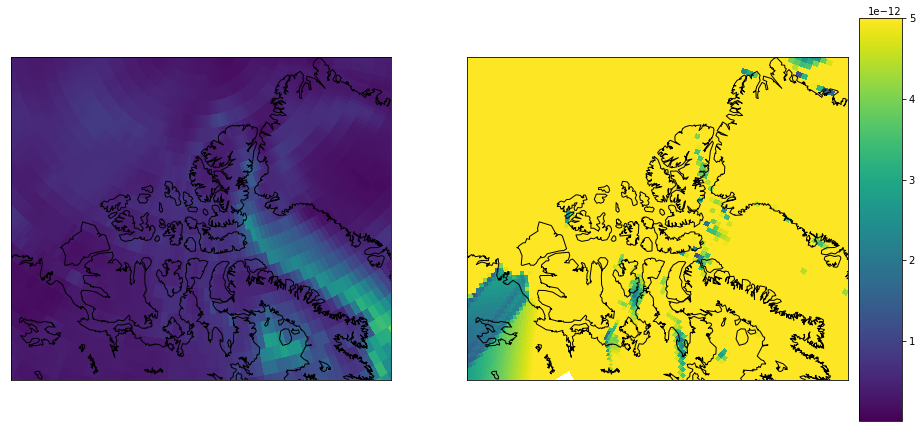

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))

proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[0])
proj1.drawcoastlines()

proj2=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[1])
proj2.drawcoastlines()

x,y   = proj1(lons, lats)
mx,my = proj2(mlons, mlats)

cbar  = proj1.pcolor(x, y, dst_a1[0, :, :], vmin=5e-15, vmax=5e-12)

proj2.pcolor(mx[::10, ::10], my[::10, ::10], d1[::10, ::10]*10**3, vmin=5e-15, vmax=5e-12)

cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

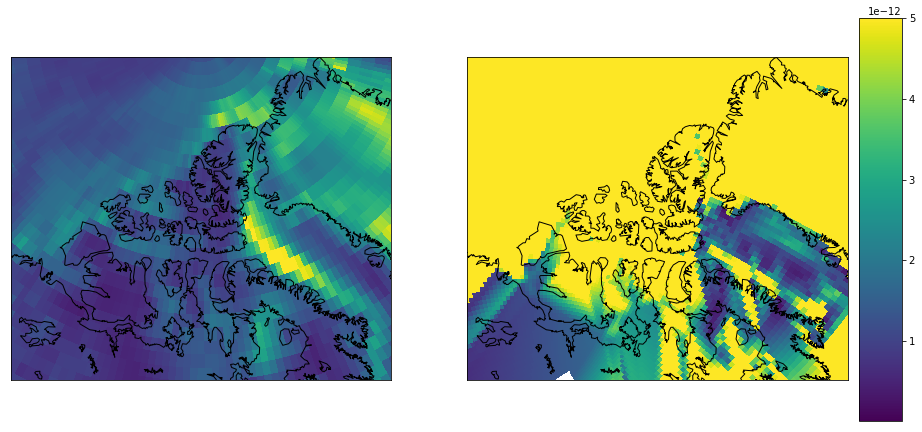

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))

proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[0])
proj1.drawcoastlines()

proj2=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[1])
proj2.drawcoastlines()

x,y   = proj1(lons, lats)
mx,my = proj2(mlons, mlats)

cbar  = proj1.pcolor(x, y, dst_a1[2, :, :], vmin=5e-15, vmax=5e-12)

proj2.pcolor(mx[::10, ::10], my[::10, ::10], d3[::10, ::10]*10**3, vmin=5e-15, vmax=5e-12)

cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

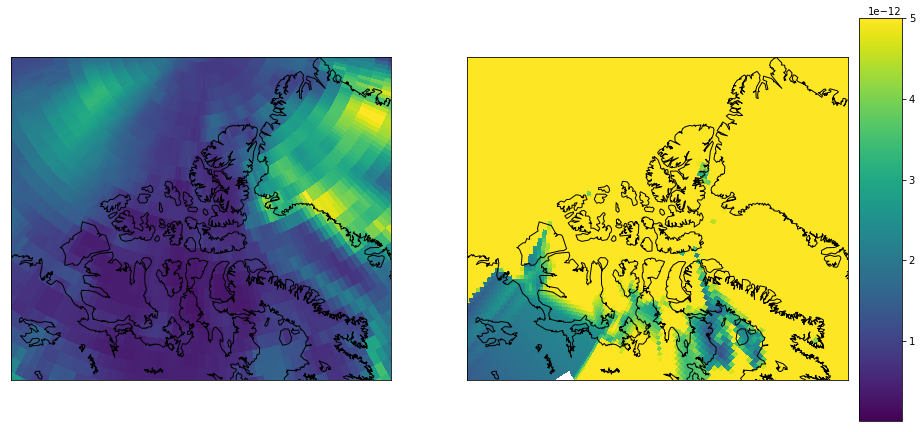

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))

proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[0])
proj1.drawcoastlines()

proj2=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[1])
proj2.drawcoastlines()

x,y   = proj1(lons, lats)
mx,my = proj2(mlons, mlats)

cbar  = proj1.pcolor(x, y, dst_a1[3, :, :], vmin=5e-15, vmax=5e-12)

proj2.pcolor(mx[::10, ::10], my[::10, ::10], d4[::10, ::10]*10**3, vmin=5e-15, vmax=5e-12)

cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

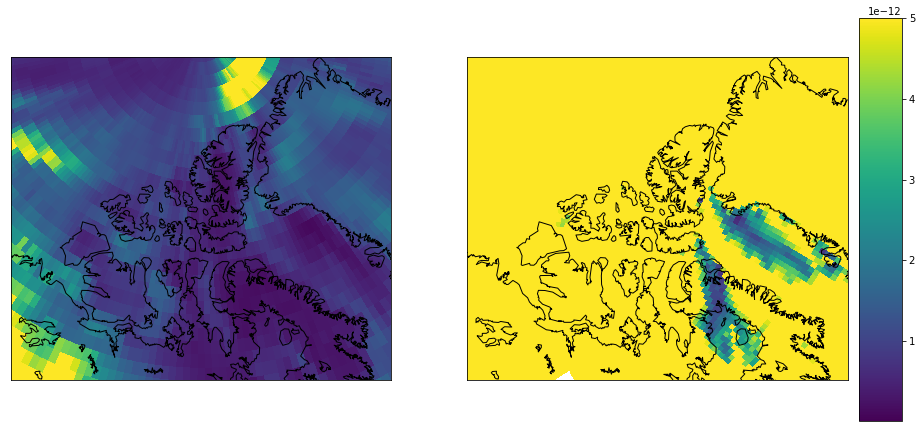

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))

proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[0])
proj1.drawcoastlines()

proj2=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[1])
proj2.drawcoastlines()

x,y   = proj1(lons, lats)
mx,my = proj2(mlons, mlats)

cbar  = proj1.pcolor(x, y, dst_a1[4, :, :], vmin=5e-15, vmax=5e-12)

proj2.pcolor(mx[::10, ::10], my[::10, ::10], d5[::10, ::10]*10**3, vmin=5e-15, vmax=5e-12)

cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

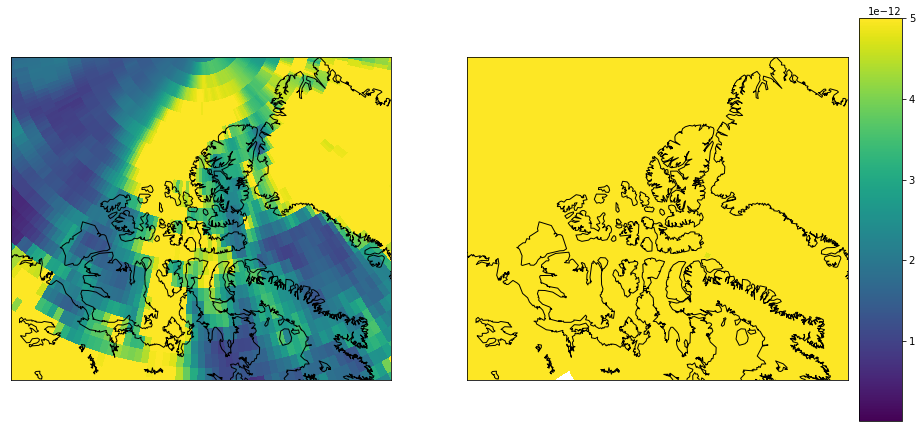

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))

proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[0])
proj1.drawcoastlines()

proj2=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[1])
proj2.drawcoastlines()

x,y   = proj1(lons, lats)
mx,my = proj2(mlons, mlats)

cbar  = proj1.pcolor(x, y, dst_a1[5, :, :], vmin=5e-15, vmax=5e-12)

proj2.pcolor(mx[::10, ::10], my[::10, ::10], d6[::10, ::10]*10**3, vmin=5e-15, vmax=5e-12)

cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

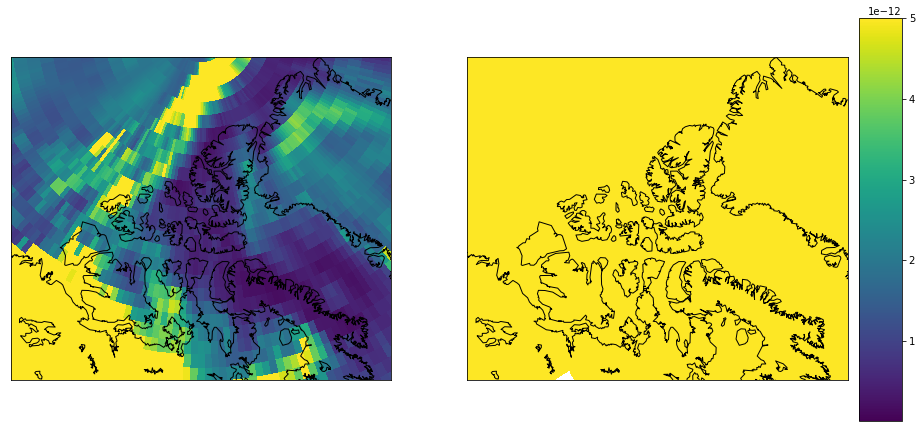

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))

proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[0])
proj1.drawcoastlines()

proj2=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[1])
proj2.drawcoastlines()

x,y   = proj1(lons, lats)
mx,my = proj2(mlons, mlats)

cbar  = proj1.pcolor(x, y, dst_a1[6, :, :], vmin=5e-15, vmax=5e-12)

proj2.pcolor(mx[::10, ::10], my[::10, ::10], d7[::10, ::10]*10**3, vmin=5e-15, vmax=5e-12)

cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

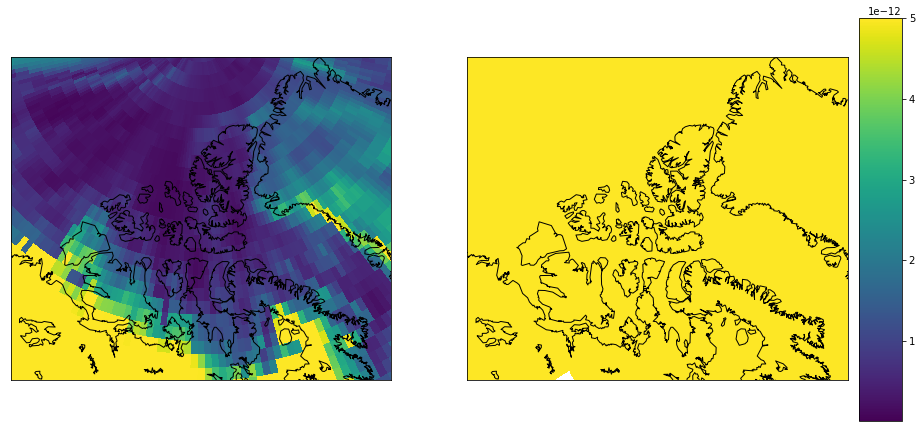

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))

proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[0])
proj1.drawcoastlines()

proj2=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[1])
proj2.drawcoastlines()

x,y   = proj1(lons, lats)
mx,my = proj2(mlons, mlats)

cbar  = proj1.pcolor(x, y, dst_a1[7, :, :], vmin=5e-15, vmax=5e-12)

proj2.pcolor(mx[::10, ::10], my[::10, ::10], d8[::10, ::10]*10**3, vmin=5e-15, vmax=5e-12)

cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

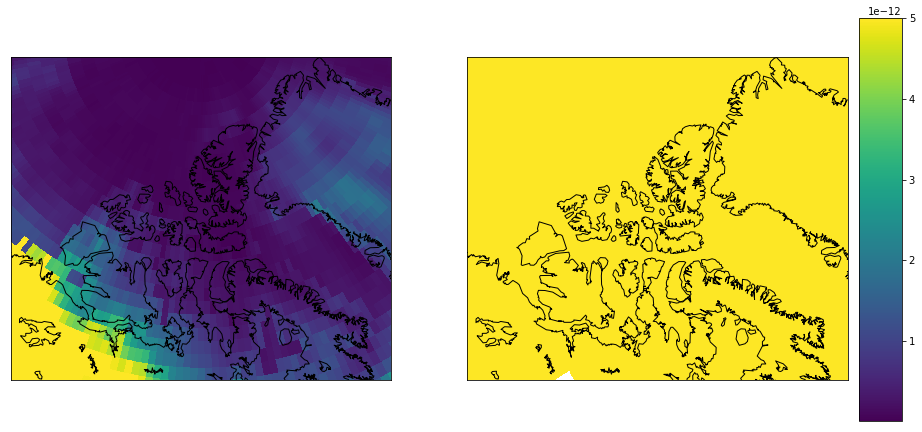

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))

proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[0])
proj1.drawcoastlines()

proj2=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[1])
proj2.drawcoastlines()

x,y   = proj1(lons, lats)
mx,my = proj2(mlons, mlats)

cbar  = proj1.pcolor(x, y, dst_a1[8, :, :], vmin=5e-15, vmax=5e-12)

proj2.pcolor(mx[::10, ::10], my[::10, ::10], d9[::10, ::10]*10**3, vmin=5e-15, vmax=5e-12)

cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

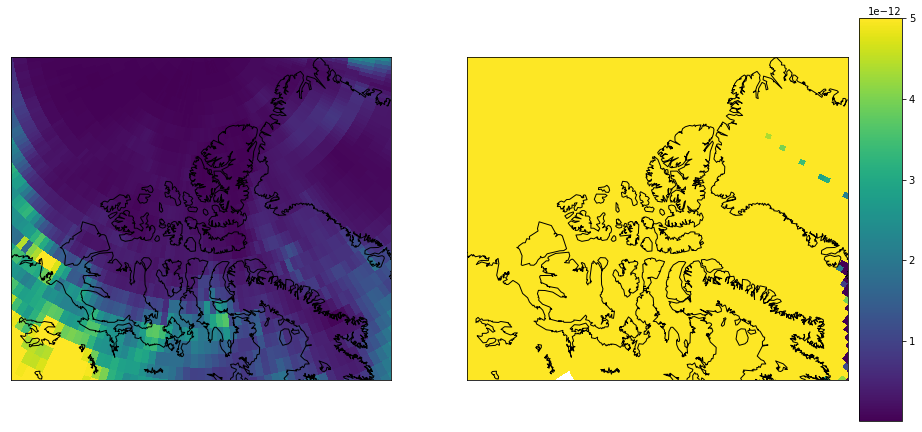

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))

proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[0])
proj1.drawcoastlines()

proj2=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[1])
proj2.drawcoastlines()

x,y   = proj1(lons, lats)
mx,my = proj2(mlons, mlats)

cbar  = proj1.pcolor(x, y, dst_a1[9, :, :], vmin=5e-15, vmax=5e-12)

proj2.pcolor(mx[::10, ::10], my[::10, ::10], d10[::10, ::10]*10**3, vmin=5e-15, vmax=5e-12)

cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

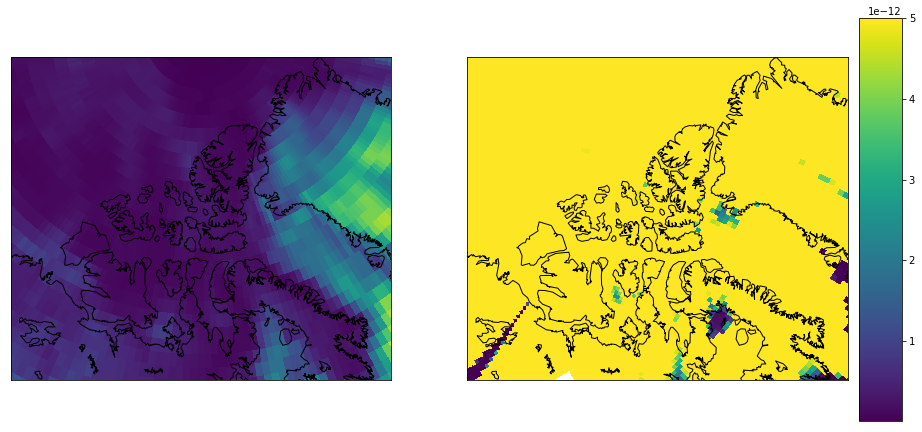

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))

proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[0])
proj1.drawcoastlines()

proj2=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[1])
proj2.drawcoastlines()

x,y   = proj1(lons, lats)
mx,my = proj2(mlons, mlats)

cbar  = proj1.pcolor(x, y, dst_a1[10, :, :], vmin=5e-15, vmax=5e-12)

proj2.pcolor(mx[::10, ::10], my[::10, ::10], d11[::10, ::10]*10**3, vmin=5e-15, vmax=5e-12)

cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

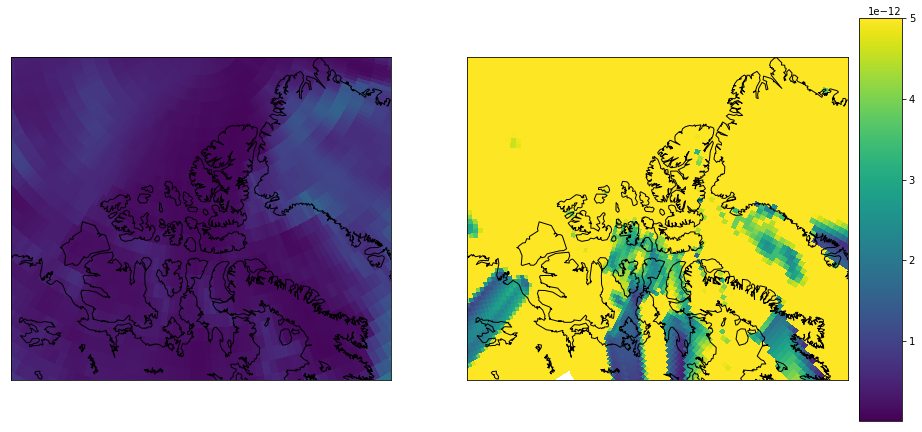

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))

proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[0])
proj1.drawcoastlines()

proj2=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='l', width=3.0e6, height=2.55e6, ax=ax[1])
proj2.drawcoastlines()

x,y   = proj1(lons, lats)
mx,my = proj2(mlons, mlats)

cbar  = proj1.pcolor(x, y, dst_a1[11, :, :], vmin=5e-15, vmax=5e-12)

proj2.pcolor(mx[::10, ::10], my[::10, ::10], d12[::10, ::10]*10**3, vmin=5e-15, vmax=5e-12)

cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

Interpolate to ANHA12 grid:

In [154]:
dst_a1 = np.array(dst_a1)
dst_a3 = np.array(dst_a3)
bc_a1 = np.array(bc_a1)

In [155]:
interp_dst_a1 = np.empty((12, 2400, 1632))
interp_dst_a3 = np.empty((12, 2400, 1632))
interp_bc_a1  = np.empty((12, 2400, 1632))

# loop over the months:
for i in range(0,12):
    interp_dst_a1[i,:,:] = interp_np(lons, lats, dst_a1[i,:,:], mlons, mlats)
    interp_dst_a3[i,:,:] = interp_np(lons, lats, dst_a3[i,:,:], mlons, mlats)
    interp_bc_a1[i,:,:]  = interp_np(lons, lats, bc_a1[i,:,:], mlons, mlats)

(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400, 1632)
(55296,) (55296,) (55296,) (2400, 1632) (2400,

### Write to NetCDF files:

In [156]:
location = '/data/brogalla/atmospheric_forcing/'

In [157]:
for i in range(1,13):
    if i < 10:
        save_file(location+'atm_flux_y'+str(file_year)+'m0'+str(i)+'.nc',interp_dst_a1[i-1,:,:],\
                  interp_dst_a3[i-1,:,:], interp_bc_a1[i-1,:,:])
    else:
        save_file(location+'atm_flux_y'+str(file_year)+'m'+str(i)+'.nc',interp_dst_a1[i-1,:,:],\
                  interp_dst_a3[i-1,:,:], interp_bc_a1[i-1,:,:])

saved  /data/brogalla/atmospheric_forcing/atm_flux_y2020m01.nc
saved  /data/brogalla/atmospheric_forcing/atm_flux_y2020m02.nc
saved  /data/brogalla/atmospheric_forcing/atm_flux_y2020m03.nc
saved  /data/brogalla/atmospheric_forcing/atm_flux_y2020m04.nc
saved  /data/brogalla/atmospheric_forcing/atm_flux_y2020m05.nc
saved  /data/brogalla/atmospheric_forcing/atm_flux_y2020m06.nc
saved  /data/brogalla/atmospheric_forcing/atm_flux_y2020m07.nc
saved  /data/brogalla/atmospheric_forcing/atm_flux_y2020m08.nc
saved  /data/brogalla/atmospheric_forcing/atm_flux_y2020m09.nc
saved  /data/brogalla/atmospheric_forcing/atm_flux_y2020m10.nc
saved  /data/brogalla/atmospheric_forcing/atm_flux_y2020m11.nc
saved  /data/brogalla/atmospheric_forcing/atm_flux_y2020m12.nc
